In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import json
from datetime import date
from dateutil.relativedelta import relativedelta
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from scipy.stats import boxcox
from pylab import rcParams
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# **Read Interest Rate Data from Federal Reserve Economic Data (FRED)**

In [ ]:
# Import or assign API key
api_key = "58394c9866a5e8ff6f27cbd23af8e6f7"

# Define the FRED API endpoint
base_url = 'https://api.stlouisfed.org/fred/'

'''
Get observation data from the FRED API
'''

# Assign endpoint
obs_endpoint = 'series/observations'

# Assign parameters
series_id = 'FEDFUNDS'
start_date = '1999-01-01'
end_date = '2024-01-31'
#ts_frequency = 'm'
#ts_units = 'pc1'

obs_params = {
    'series_id': series_id,
    'api_key': api_key,
    'file_type': 'json',
    'observation_start': start_date,
    'observation_end': end_date,
    # 'frequency': ts_frequency
    # 'units': ts_units
}

# Make request to FRED API
response = requests.get(base_url + obs_endpoint, params=obs_params)

# Format data
if response.status_code == 200:
    res_data = response.json()
    obs_data = pd.DataFrame(res_data['observations'])
    obs_data['date'] = pd.to_datetime(obs_data['date'])
    #obs_data.set_index('date', inplace=True)
    obs_data['FUND RATE'] = obs_data['value'].astype(float)
    obs_data = obs_data.drop(columns=["realtime_start", "realtime_end","value"])

else:
    print('Failed to retrieve data. Status code:', response.status_code)

In [ ]:
df = obs_data.drop_duplicates(subset=['date'], keep="last").reset_index(drop=True)
df.head()

,date,FUND RATE
0,1999-01-01,4.63
1,1999-02-01,4.76
2,1999-03-01,4.81
3,1999-04-01,4.74
4,1999-05-01,4.74


In [ ]:
df.sort_values(by='date',inplace=True)

In [ ]:
df.date= pd.to_datetime(df.date)

In [ ]:
df.set_index('date',inplace=True)
df.tail()

,FUND RATE
date,
2023-09-01,5.33
2023-10-01,5.33
2023-11-01,5.33
2023-12-01,5.33
2024-01-01,5.33


In [ ]:
df.head()

,FUND RATE
date,
1999-01-01,4.63
1999-02-01,4.76
1999-03-01,4.81
1999-04-01,4.74
1999-05-01,4.74


In [ ]:
df.index.max(),df.index.min()

(Timestamp('2024-01-01 00:00:00'), Timestamp('1999-01-01 00:00:00'))

In [ ]:
#Export Dataset to google drive
path = '/content/drive/MyDrive/DATA 698/Data Science Project/interestRate.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f,index=True)

In [ ]:
# import matplotlib.pyplot as plt

# # Convert 'Date' to datetime type
# data['date'] = pd.to_datetime(df['date'])

# # Plotting the data
# plt.figure(figsize=(12, 6))
# plt.plot(data['date'], data['FUND RATE'], marker='o', linestyle='-', color='b')
# plt.title('Interest Rate Over Time')
# plt.xlabel('Date')
# plt.ylabel('Interest Rate (%)')
# plt.grid(True)
# plt.show()

# **Histogram**

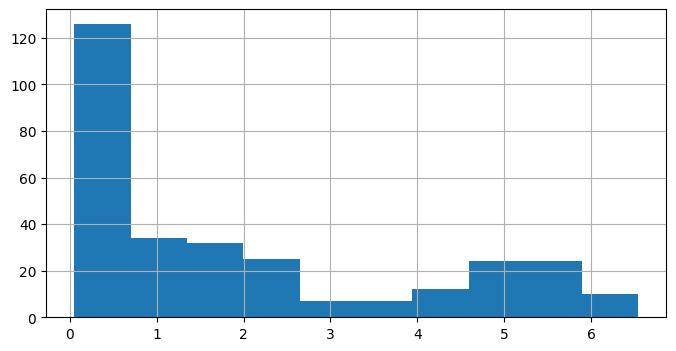

In [ ]:
fig = df['FUND RATE'].hist(figsize = (8,4))

# **Box Plot**

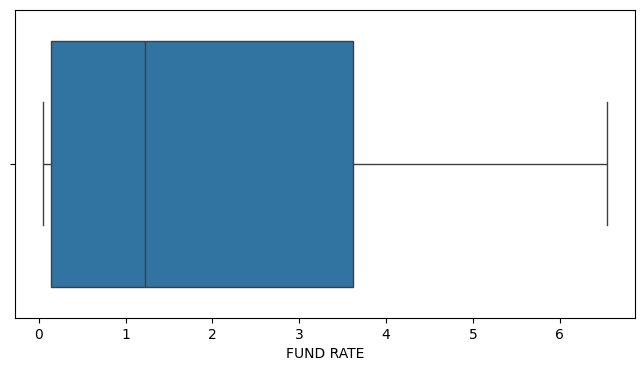

In [ ]:
fig = plt.subplots(figsize=(8, 4))
ax = sns.boxplot(x=df['FUND RATE'],whis=1.5)

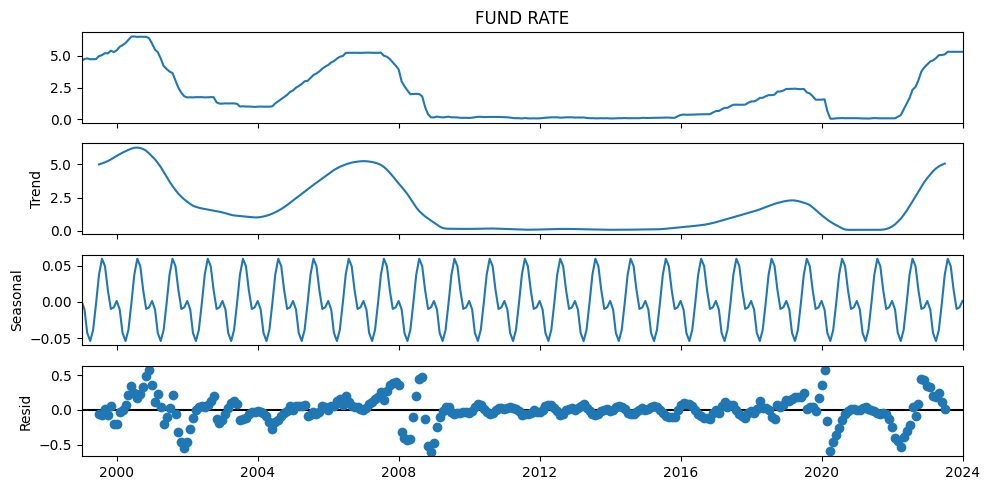

In [ ]:
rcParams['figure.figsize'] = 10,5
decomposition = sm.tsa.seasonal_decompose(df['FUND RATE'], model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
#Transform original data with log
df_log_scaled = np.log(df)

In [ ]:
#subtract the 12 moving average from original data
ma = df.rolling(window=12).mean()
df_minus_ma = df - ma
df_minus_ma.dropna(inplace=True)

In [ ]:
#subtract the 12 moving average from log scaled data
ma01 = df_log_scaled.rolling(window=12).mean()
df_log_scaled_minus_ma = df - ma01
df_log_scaled_minus_ma.dropna(inplace=True)

In [ ]:
dfCox = df.copy()
#dfCox

In [ ]:
#Boxcox Transformation
dfCox['Boxcox'], lam = boxcox(dfCox['FUND RATE'])
dfCox["Boxcox_diff"] = dfCox["Boxcox"].diff()
dfCox.drop(['FUND RATE', 'Boxcox'], inplace=True, axis=1)
dfCox.dropna(inplace=True)


In [ ]:
dfCox.head()

,Boxcox_diff
date,
1999-02-01,0.033071
1999-03-01,0.012507
1999-04-01,-0.017542
1999-05-01,0.000000
1999-06-01,0.005035


In [ ]:
def test_stationarity(data):
  data.dropna(inplace=True)
  rolmean = data.rolling(window=12).mean()
  rolstd = data.rolling(window=12).std()

  orig = plt.plot(data,label="Original")
  mean = plt.plot(rolmean,label="Rolling mean")
  std = plt.plot(rolstd,label="Rolling std")
  plt.legend()

  dftest = adfuller(data)
  dfoutput = pd.Series(dftest[0:4],index=["The test statistics","Mackinnon's approximate p-value","#usedLags","NOBS"])
  print(dfoutput)


  #ACF and PCF for differenced data log scaled - MA
  acf_lag_df_data = acf(data,nlags=70)
  pacf_lag_df_data = pacf(data,nlags=70)

  fig,ax = plt.subplots(1,2,figsize=(15,5))

  plot_acf(acf_lag_df_data,ax=ax[0])
  plot_pacf(pacf_lag_df_data,ax=ax[1])
  plt.show()

  stepwise_fit = auto_arima(data, trace=True,suppress_warnings=True)


The test statistics                 -4.197193
Mackinnon's approximate p-value      0.000666
#usedLags                            5.000000
NOBS                               284.000000
dtype: float64


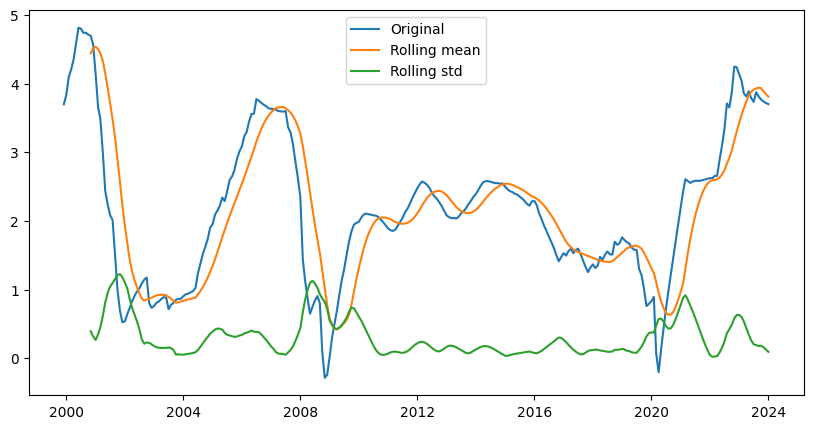

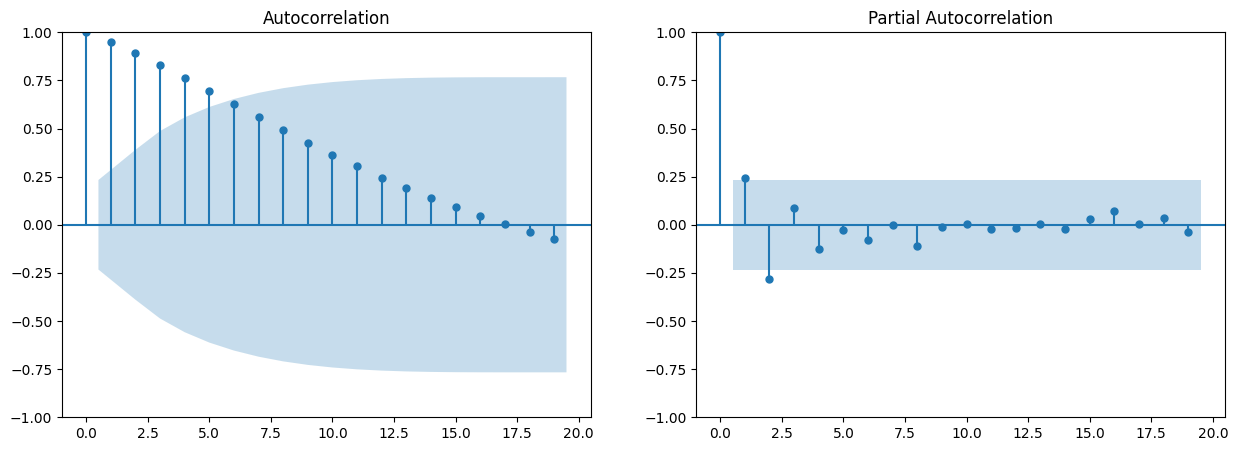

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-370.554, Time=1.62 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=871.522, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-220.359, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=504.036, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1333.755, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-339.200, Time=1.00 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-357.114, Time=0.71 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-369.897, Time=1.16 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-369.896, Time=1.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-331.863, Time=0.51 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-352.471, Time=1.49 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-357.742, Time=1.09 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-367.703, Time=1.39 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-357.979, Time=0.74 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0

In [ ]:
test_stationarity(df_log_scaled_minus_ma)

# Build ModelTo Test the AR, I and MA Parameters

In [ ]:
# Split train and test
train_data = df.iloc[:-12]
print('Train size: ', len(train_data))
test_data = df.iloc[-12:]
print('Test size: ',len(test_data))

Train size:  289
Test size:  12


In [ ]:
# Build ARIMA Model
my_order = (2,0,2)
model=ARIMA(train_data,order=my_order)
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              FUND RATE   No. Observations:                  289
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 176.588
Date:                Sun, 28 Apr 2024   AIC                           -341.177
Time:                        05:34:48   BIC                           -319.178
Sample:                    01-01-1999   HQIC                          -332.362
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0946      0.709      2.956      0.003       0.706       3.483
ar.L1          1.9415      0.029     65.961      0.000       1.884       1.999
ar.L2         -0.9464      0.029    -32.429      0.000      -1.004      -0.889
ma.L1         -0.3549      0.063     -5.642      0.000      -0.478      -0.232
ma.L2         -0.2726      0.047     -5.848      0.000      -0.364      -0.181
sigma2         0.0169      0.001     26.009      0.000       0.016       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2526.20
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -2.17
Prob(H) (two-sided):                  0.35   Kurtosis:                        16.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'INTEREST RATE')

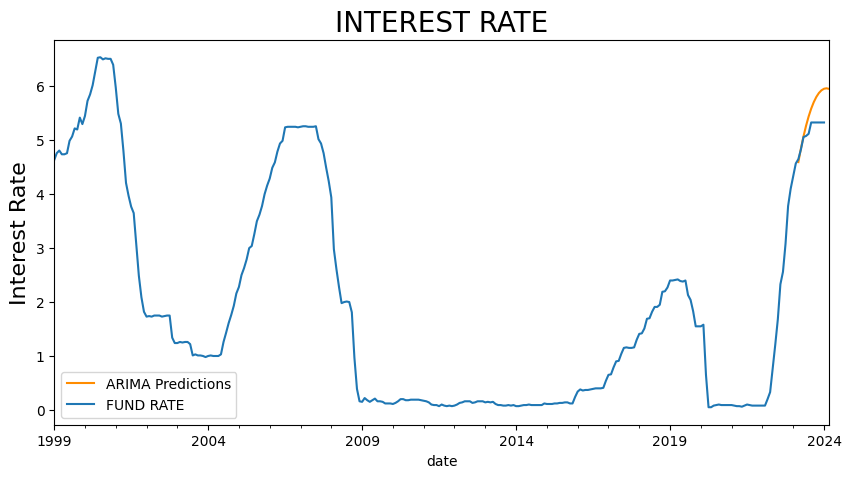

In [ ]:
start=len(train_data)
end=len(train_data)+len(test_data)
pred=model.predict(start=start,end=end,type='levels').rename('ARIMA Predictions')
test_date = pd.date_range('2023-03-01', '2024-03-01', freq='MS')
predictions =  pd.DataFrame(pred).set_index(test_date)
Test_df =  pd.DataFrame(test_data)
residuals = test_data['FUND RATE'] - predictions['ARIMA Predictions']
#print(residuals)
predictions.plot(legend=True,color='darkorange')
df['FUND RATE'].plot(legend=True)
plt.ylabel('Interest Rate', fontsize=16)
plt.title('INTEREST RATE', fontsize=20)

Text(0, 0.5, 'Error')

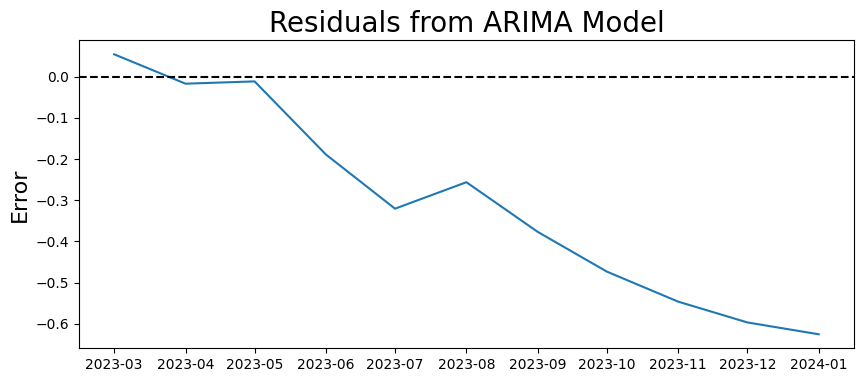

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [ ]:
print('Mean Absolute Percent Error(%):', round(np.mean(abs(residuals/test_data['FUND RATE'] * 100)),4))

Mean Absolute Percent Error(%): 5.969


In [ ]:
print('Root Mean Squared Error(%):', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error(%): 38.36511587152515


# Using the Rolling Forecast Origin

In [ ]:
rolling_predictions = test_data.copy()
pred_list = []
for train_end in test_data.index:
  train_data = df[:train_end-timedelta(days=1)]
  model = ARIMA(train_data, order=my_order)
  model_fit = model.fit()
  pred = model_fit.forecast()
  pred_list.append(pred.values)
print(pred)
prediction = pd.DataFrame(pred_list)

2024-01-01    5.312291
Freq: MS, dtype: float64


In [ ]:
test_date = pd.date_range('2023-04-01', '2024-03-01', freq='MS')

In [ ]:
col2 = ['pred_var']
prediction.columns = col2
prediction.set_index(test_date,inplace=True)

In [ ]:
prediction

,pred_var
2023-04-01,4.595418
2023-05-01,4.805744
2023-06-01,4.771519
2023-07-01,5.006744
2023-08-01,5.228835
2023-09-01,5.118960
2023-10-01,5.180769
2023-11-01,5.461777
2023-12-01,5.316262
2024-01-01,5.344644


In [ ]:
rolling_residuals = test_data['FUND RATE'] - prediction['pred_var']

Text(0, 0.5, 'Error')

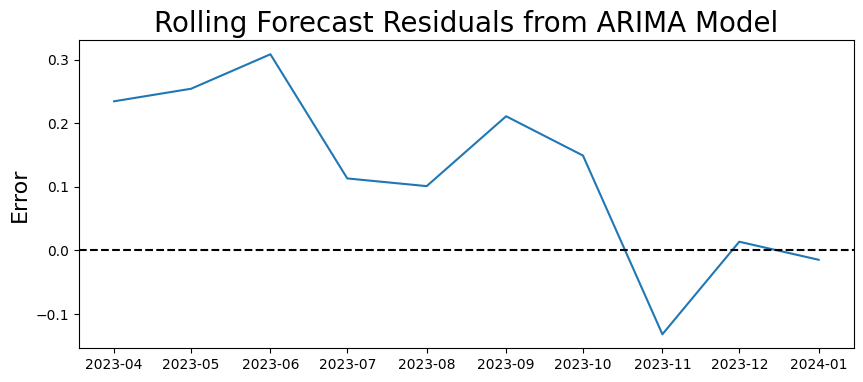

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [ ]:
start_date = datetime(2023,2,1)
end_date = datetime(2024,1,1)

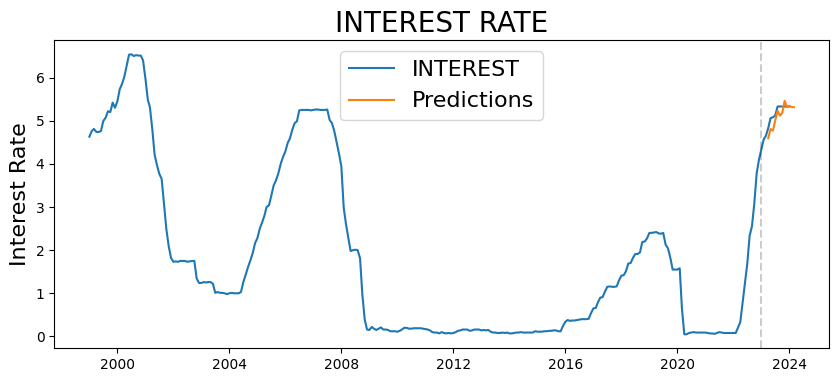

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(prediction['pred_var'])
plt.legend(('INTEREST', 'Predictions'), fontsize=16)
plt.title('INTEREST RATE', fontsize=20)
plt.ylabel('Interest Rate', fontsize=16)
for year in range(start_date.year,end_date.year):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [ ]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data['FUND RATE']))*100,4))

Mean Absolute Percent Error: 2.9828


In [ ]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 17.957527222756596


# Forecasting The Future

In [ ]:
df.index.max()

Timestamp('2024-01-01 00:00:00')

In [ ]:
#12 months future projection
future_index = pd.date_range(df.index.max() + relativedelta(months=1),df.index.max() + relativedelta(months=12), freq='MS')

In [ ]:
future_index

DatetimeIndex(['2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01',
               '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01', '2024-12-01', '2025-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [ ]:
df_to_predict = pd.DataFrame(index=future_index,columns=df.columns)

In [ ]:
#Concatenate Initial dataset and future dataset
df_all = pd.concat([df, df_to_predict], axis=0)
df_all.head()

,FUND RATE
1999-01-01,4.63
1999-02-01,4.76
1999-03-01,4.81
1999-04-01,4.74
1999-05-01,4.74


In [ ]:
df_all.tail()

,FUND RATE
2024-09-01,NaN
2024-10-01,NaN
2024-11-01,NaN
2024-12-01,NaN
2025-01-01,NaN


In [ ]:
# Split train and test
train_data02 = df_all.iloc[:-24]
print('Train size: ', len(train_data02))
test_data02 = df_all.iloc[-24:]
print('Test size: ',len(test_data02))

Train size:  289
Test size:  24


In [ ]:
pred_list02 = []
for train_end in test_data02.index:
  train_data02 = df_all[:train_end-timedelta(days=1)]
  model02 = ARIMA(train_data02, order=my_order)
  model_fit = model02.fit()

  pred02 = model_fit.forecast()
  pred_list02.append(pred02.values)

prediction02 = pd.DataFrame(pred_list02)

In [ ]:
col02 = ['pred_var']
prediction02.columns = col02
prediction02.set_index(test_data02.index,inplace=True)

In [ ]:
prediction02

,pred_var
2023-02-01,4.595418
2023-03-01,4.805744
2023-04-01,4.771519
2023-05-01,5.006744
2023-06-01,5.228835
2023-07-01,5.118960
2023-08-01,5.180769
2023-09-01,5.461777
2023-10-01,5.316262
2023-11-01,5.344644


In [ ]:
start_date = datetime(2023,2,1)
end_date = datetime(2024,4,1)

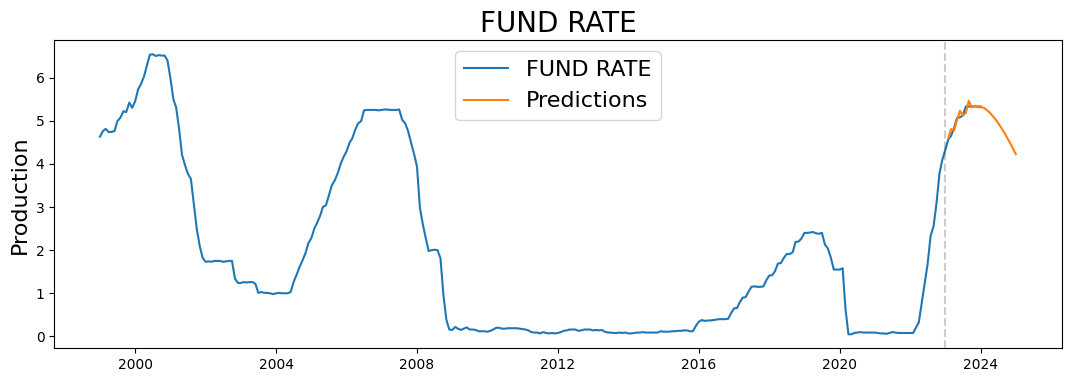

In [ ]:
plt.figure(figsize=(13,4))
plt.plot(df_all)
plt.plot(prediction02['pred_var'])
plt.legend(('FUND RATE', 'Predictions'), fontsize=16)
plt.title('FUND RATE', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)